### Paso 1. Librerías

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
pd.options.display.float_format = '{:,.0f}'.format

### Paso 2. Carga y división del conjunto de datos

In [2]:
# cargamos los datos
data = np.load('proyecto_training_data.npy')

In [3]:
# los transformamos en un dataframe con columnas nombradas de acuerdo al Data fields.txt
df_data = pd.DataFrame(data,columns=['SalePrice','OveralQuad','1stFlrSF',
                                     'TotRmsAbvGrd','YearBuilt','LotFrontage']
                      )
print(f"Cantidad de registros: {df_data.shape[0]}")
print(f"Cantidad de columnas: {df_data.shape[1]}\n")
df_data.head()

Cantidad de registros: 1460
Cantidad de columnas: 6



,SalePrice,OveralQuad,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
0,"208,500",7,856,8,"2,003",65
1,"181,500",6,"1,262",6,"1,976",80
2,"223,500",7,920,6,"2,001",68
3,"140,000",7,961,7,"1,915",60
4,"250,000",8,"1,145",9,"2,000",84


In [4]:
# se seleccionan aleatoriamente 1168 índices (el 80%) del data set para el set de entrenamiento
training_index = []
cant_reg = data.shape[0]
while len(training_index) < int(cant_reg*0.8):
    num = random.randint(0,cant_reg - 1)
    # No se toman índices repetidos
    if num in training_index:
        continue
    else:
        training_index.append(num)

In [5]:
# para el set de prueba se seleccionan los demás índices que no se tomaron para el
# set de entrenamiento. Se hace una diferencia de conjuntos.
total_index = [i for i in range(0,cant_reg-1)]
test_index = list(set(total_index).difference(set(training_index)))

In [6]:
# se forman los set de entrenamiento y prueba con los índices obtenidos anteriormente
training_data = data[np.array(training_index)]
test_data = data[np.array(test_index)]

### Paso 3. Análisis explotario de variables

In [7]:
for col in df_data.columns:
    print(f'Variable {col}\n{30*"-"}')
    mean_price = df_data[col].mean() 
    print(f'{mean_price = :}')
    min_price = df_data[col].min() 
    print(f'{min_price = :}')
    max_price = df_data[col].max() 
    print(f'{max_price = :}')
    peak_price = max_price - min_price 
    print(f'{peak_price = :}')
    std_price = df_data[col].std() 
    print(f'{std_price = :}')
    print(f"{30*'-'}\n")

Variable SalePrice
------------------------------
mean_price = 180921.19589041095
min_price = 34900.0
max_price = 755000.0
peak_price = 720100.0
std_price = 79442.50288288663
------------------------------

Variable OveralQuad
------------------------------
mean_price = 6.0993150684931505
min_price = 1.0
max_price = 10.0
peak_price = 9.0
std_price = 1.3829965467415923
------------------------------

Variable 1stFlrSF
------------------------------
mean_price = 1162.626712328767
min_price = 334.0
max_price = 4692.0
peak_price = 4358.0
std_price = 386.5877380410738
------------------------------

Variable TotRmsAbvGrd
------------------------------
mean_price = 6.517808219178082
min_price = 2.0
max_price = 14.0
peak_price = 12.0
std_price = 1.625393290584064
------------------------------

Variable YearBuilt
------------------------------
mean_price = 1971.267808219178
min_price = 1872.0
max_price = 2010.0
peak_price = 138.0
std_price = 30.202904042525265
------------------------------



### Paso 4. Análisis gráfico por variable

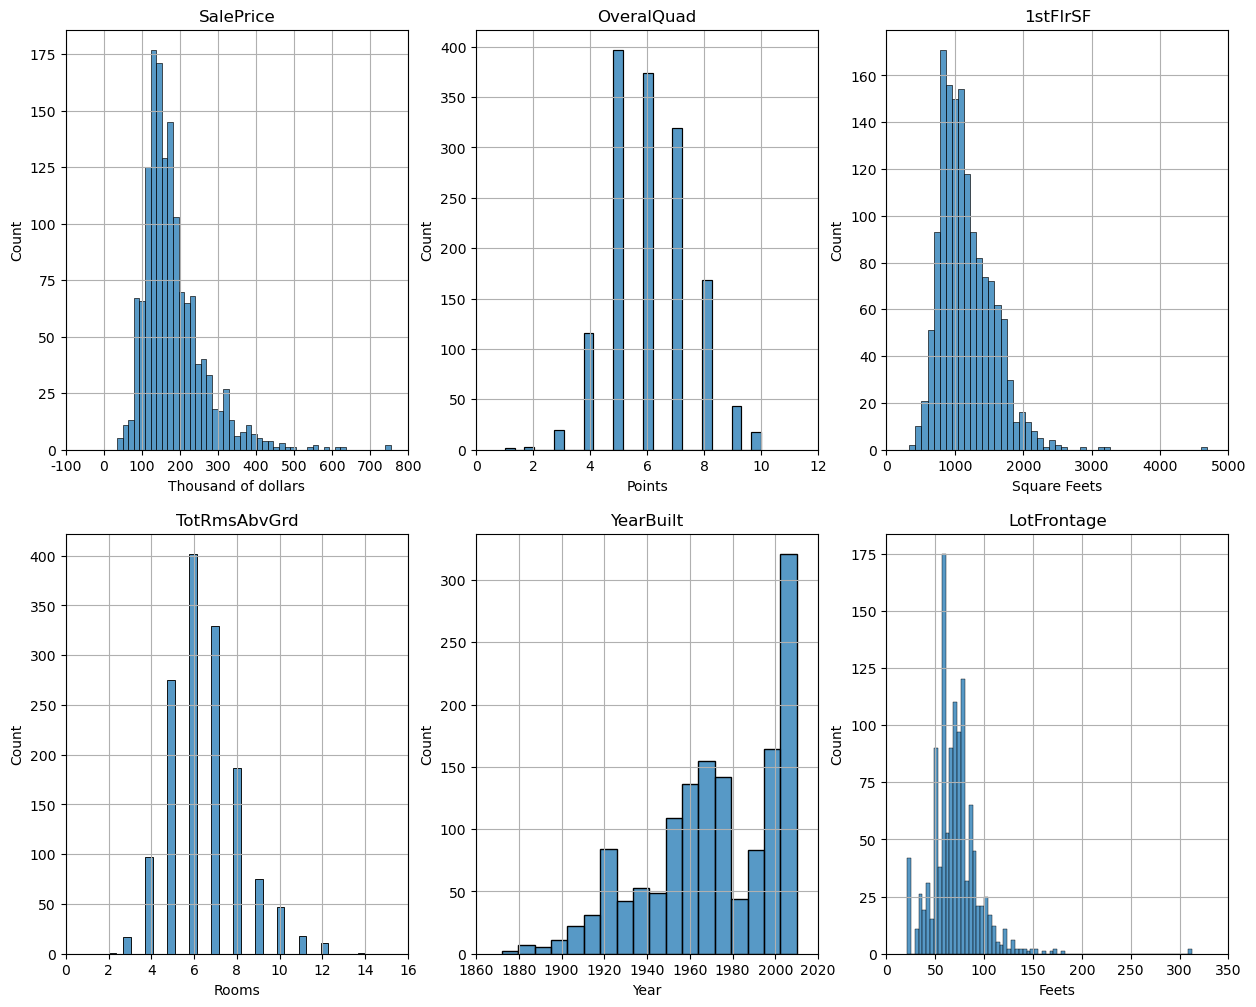

In [8]:
nxm = len(df_data.columns)
n = 2
m = 3
units = ['Thousand of dollars','Points','Square Feets','Rooms','Year','Feets']
fig, ax =  plt.subplots(n,m, figsize=(15,12))
for i, col in enumerate(df_data.columns):
    graf = sns.histplot(data=df_data[col], ax=ax[i//m,i%m])
    graf.set_title(col)
    xtick = graf.get_xticks() if col != 'SalePrice' else graf.get_xticks()/1e3
    xticklabel = [f"{int(val)}" for val in graf.get_xticks()] if col != 'SalePrice' else [f"{int(val)}" for val in graf.get_xticks()/1e3]
    graf.set_xticks(graf.get_xticks())
    graf.set_xticklabels(xticklabel)
    graf.set_xlabel(units[i])
    graf.grid()
plt.show()

### Paso 5. Correlación

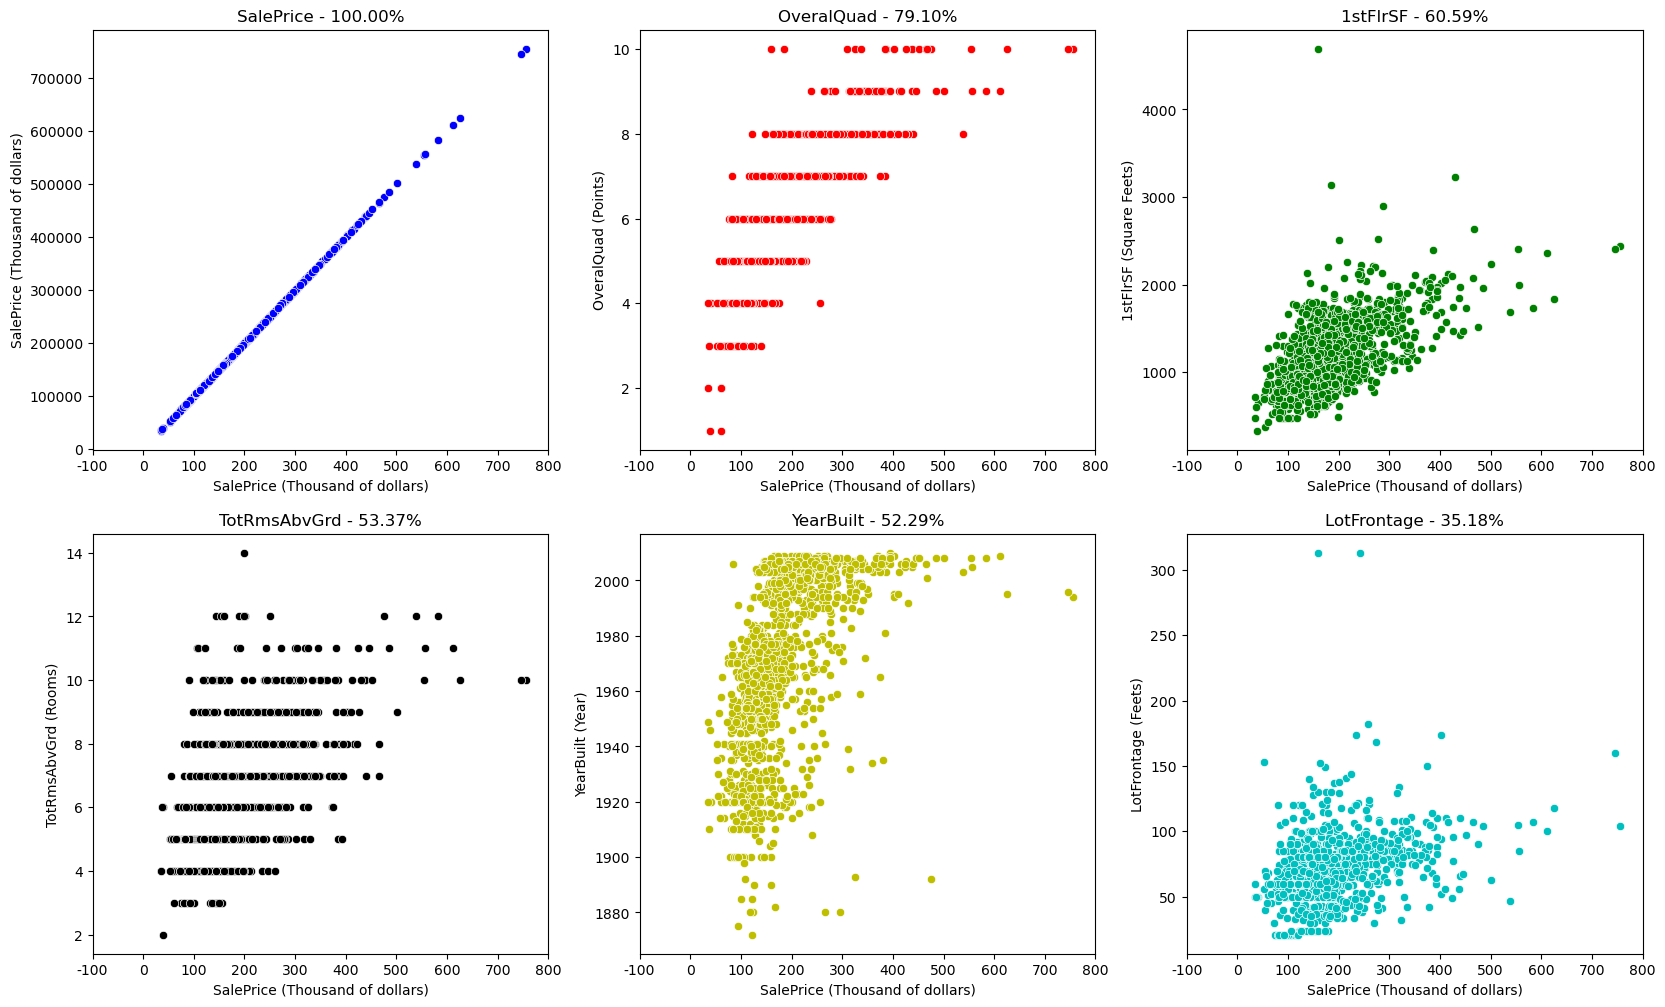

In [9]:
fig, ax =  plt.subplots(n,m, figsize=(20,12))
colors = ['b','r','g','k','y','c']
units = ['Thousand of dollars','Points','Square Feets','Rooms','Year','Feets']
for i, col in enumerate(df_data.columns):
    correlacion = df_data.SalePrice.corr(df_data[col])
    scat = sns.scatterplot(x=df_data.SalePrice,y=df_data[col], ax=ax[i//m,i%m], color=colors[i])
    xtick = scat.get_xticks()/1e3
    xticklabel = [f"{int(val)}" for val in scat.get_xticks()/1e3]
    scat.set_xticks(scat.get_xticks())
    scat.set_xticklabels(xticklabel)
    scat.set_title(f"{col} - {correlacion*100:.2f}%")
    scat.set_xlabel("SalePrice (Thousand of dollars)")
    scat.set_ylabel(f"{col} ({units[i]})")
plt.show()

Con base en el anterior análisis, se escogen los campos ***OveralQuad*** y ***1stFlrSF*** para realizar los modelos,
ya que presentan la mayor correlación con la variable de salida ***SalePice***, lo que significa que el material y el acabado
de la casa, y  el área del primer nivel influencian más en el precio de la casa.

### Paso 6. Función para entrenar modelo

In [10]:
def entrenar_modelo(x, y, epochs, imprimir_error_cada, alpha):
    iters = dict()
    vec_err = []
    ones = np.ones_like(x.reshape(-1,1))
    A = np.hstack([x.reshape(-1,1), ones])
    b0 = 10000.0
    b1 = 5000.0
    betas = np.array([b1,b0])
    for n in range(1,epochs+1):
        y_pred = np.matmul(A, betas)
        err = ((y - y_pred)**2).sum()/(2*len(y))
        vec_err.append(err)
        grad = np.matmul((y_pred - y)/len(y), A)
        betas -= alpha*grad
        iters[n] = {'b1':betas[0], 'b0':betas[1]}
        if n%imprimir_error_cada == 0:
            print(f'Iteración {n}: Error {err}')
    return iters, np.array(vec_err)

In [78]:
def plot_error(error):
    errSeries = pd.Series(error)
    plt.figure(figsize=(15,5))
    plt.plot(errSeries.index, errSeries.values, color='r')
    plt.title('Error del Modelo')
    plt.xlabel('No. Iteración')
    plt.ylabel('Error')
    plt.grid(linewidth=0.5)
    plt.show()

In [38]:
def plot_model(model, n=5):
    x = np.arange(0,len(model)+1,5000)
    plt.figure(figsize=(15,5))
    for i in range(1,len(model)+1):
        if i%n == 0:
            plt.plot(x, model[i]['b1']*x + model[i]['b0'], linewidth=1, label=f"y = {model[i]['b1']:.0f}x + {model[i]['b0']:.0f}")
    plt.title('Modelos')
    plt.xlabel('x')
    plt.ylabel('y(x)')
    plt.xticks(x)
    plt.legend()
    plt.grid()
    plt.show()

In [31]:
y_train_ov = training_data[:,0]
x_train_ov = training_data[:,1]

In [71]:
overalQuadModel, OvModelError = entrenar_modelo(x_train_ov,y_train_ov,50000,1000,1e-3) #Error 1223799089.3351064

Iteración 1000: Error 1502678886.9387152
Iteración 2000: Error 1477945986.049517
Iteración 3000: Error 1455477029.8446734
Iteración 4000: Error 1435064786.4448035
Iteración 5000: Error 1416520993.0964637
Iteración 6000: Error 1399674619.8189366
Iteración 7000: Error 1384370291.9894216
Iteración 8000: Error 1370466857.318072
Iteración 9000: Error 1357836083.9960515
Iteración 10000: Error 1346361478.0095894
Iteración 11000: Error 1335937208.7120783
Iteración 12000: Error 1326467132.7447438
Iteración 13000: Error 1317863907.3034647
Iteración 14000: Error 1310048184.5733864
Iteración 15000: Error 1302947879.9015622
Iteración 16000: Error 1296497506.957969
Iteración 17000: Error 1290637573.7530532
Iteración 18000: Error 1285314033.9412696
Iteración 19000: Error 1280477788.349959
Iteración 20000: Error 1276084232.1361594
Iteración 21000: Error 1272092843.394756
Iteración 22000: Error 1268466809.423696
Iteración 23000: Error 1265172687.1992953
Iteración 24000: Error 1262180094.9301937
Iteraci

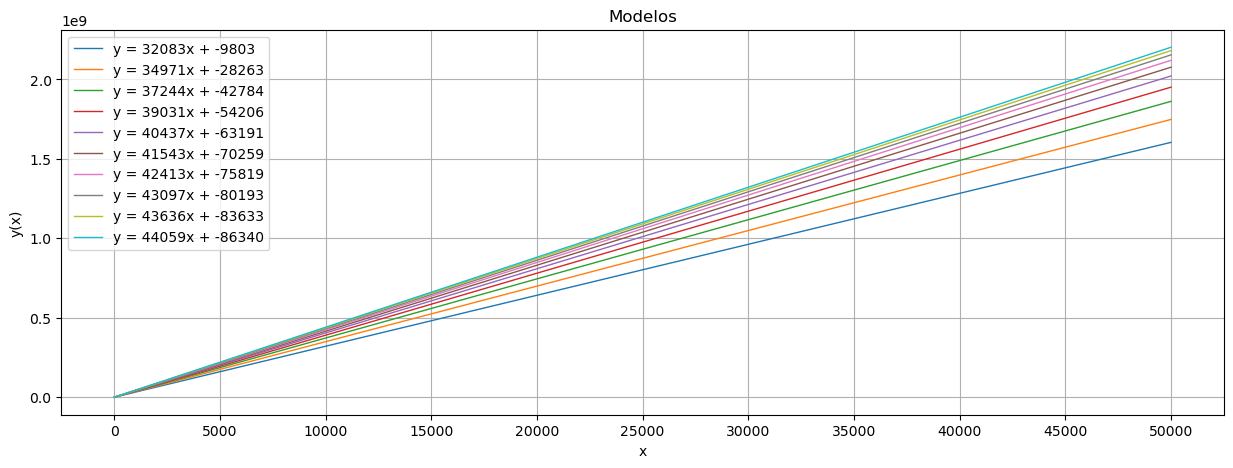

In [72]:
plot_model(overalQuadModel,5000)

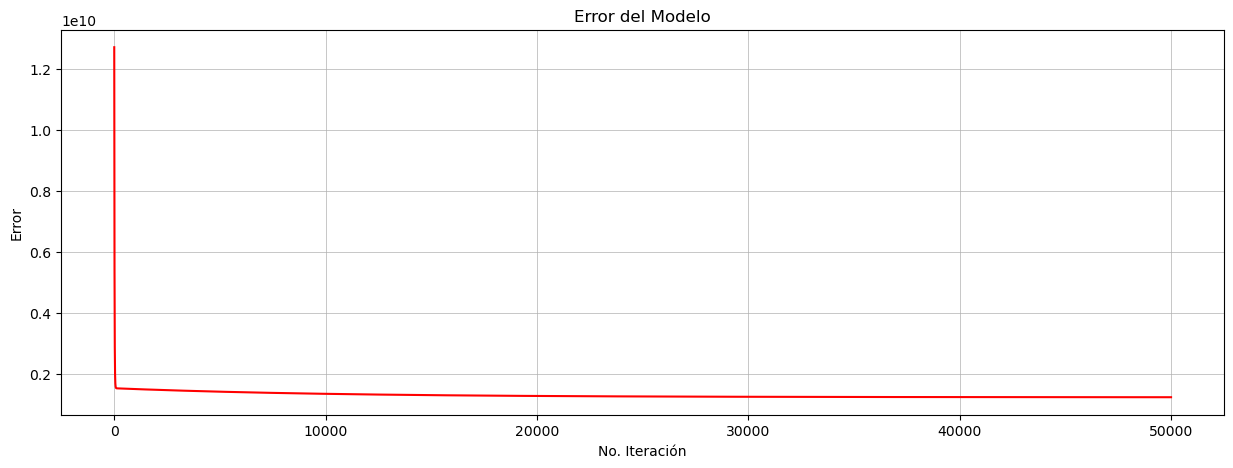

In [79]:
plot_error(OvModelError)

In [74]:
y_train_fl = training_data[:,0]
x_train_fl = training_data[:,2]

In [75]:
firstFlrdModel, FlrModelError = entrenar_modelo(x_train_fl,y_train_fl,50000,5000,1.3e-10)

Iteración 5000: Error 2509623049291.511
Iteración 10000: Error 356375769567.7519
Iteración 15000: Error 52152389269.402275
Iteración 20000: Error 9169929243.036385
Iteración 25000: Error 3097115677.0321302
Iteración 30000: Error 2239113023.539298
Iteración 35000: Error 2117889382.071264
Iteración 40000: Error 2100762192.3571777
Iteración 45000: Error 2098342358.7036006
Iteración 50000: Error 2098000466.4077382


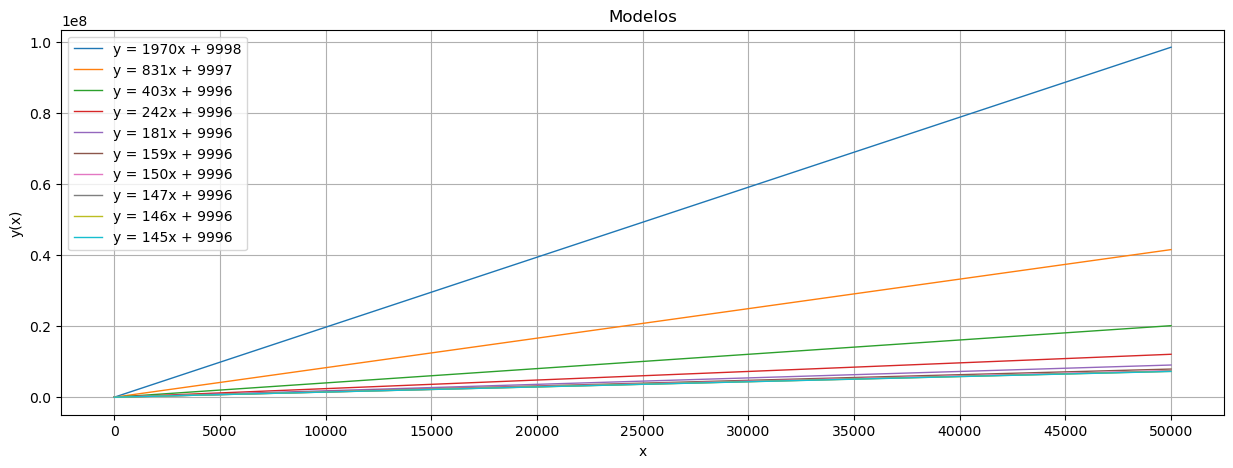

In [76]:
plot_model(firstFlrdModel,5000)

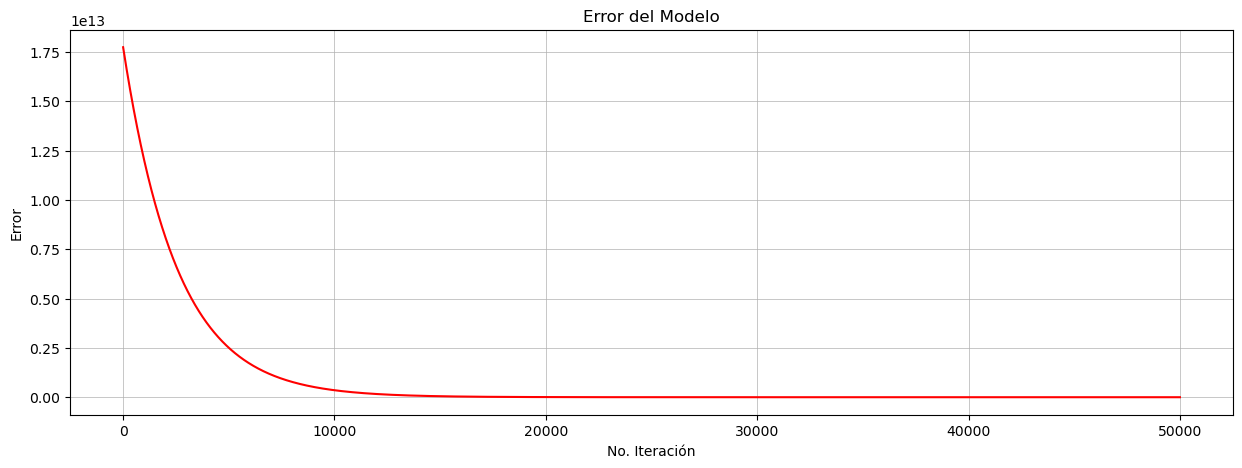

In [80]:
plot_error(FlrModelError)